In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load



# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# If you see a warning "Failed to establish a new connection" running this cell,
# go to "Settings" on the right hand side, 
# and turn on internet. Note, you need to be phone verified.
# We need this library to read HDF files.
if not os.path.exists('/opt/conda/lib/python3.7/site-packages/tables'):
    !pip install --quiet tables

/kaggle/input/xandxt/X.npy
/kaggle/input/xandxt/Xt.npy
/kaggle/input/open-problems-multimodal/sample_submission.csv
/kaggle/input/open-problems-multimodal/train_cite_targets.h5
/kaggle/input/open-problems-multimodal/metadata_cite_day_2_donor_27678.csv
/kaggle/input/open-problems-multimodal/test_multi_inputs.h5
/kaggle/input/open-problems-multimodal/evaluation_ids.csv
/kaggle/input/open-problems-multimodal/train_cite_inputs.h5
/kaggle/input/open-problems-multimodal/train_multi_targets.h5
/kaggle/input/open-problems-multimodal/train_multi_inputs.h5
/kaggle/input/open-problems-multimodal/metadata.csv
/kaggle/input/open-problems-multimodal/test_cite_inputs_day_2_donor_27678.h5
/kaggle/input/open-problems-multimodal/test_cite_inputs.h5


# Import Packages

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import scipy

path = '/kaggle/input/open-problems-multimodal/'

# Data Analysis

## Metadata Table

In [ ]:
meta = pd.read_csv(path + 'metadata.csv')
meta.head()

,cell_id,day,donor,cell_type,technology
0,c2150f55becb,2,27678,HSC,citeseq
1,65b7edf8a4da,2,27678,HSC,citeseq
2,c1b26cb1057b,2,27678,EryP,citeseq
3,917168fa6f83,2,27678,NeuP,citeseq
4,2b29feeca86d,2,27678,EryP,citeseq


In [ ]:
meta.nunique()

cell_id       281528
day                5
donor              4
cell_type          8
technology         2
dtype: int64

We have 281 528 unique cells referenced in the meta table. Cells come from 4 different donors, and have been measured over 5 days. 8 cell types have been used for this study.

As we are focusing here on the 'citeseq' technology, let's filter out our dataset:

In [ ]:
meta_citeseq = meta[meta.technology == "citeseq"]
meta_citeseq.nunique()

cell_id       119651
day                4
donor              4
cell_type          7
technology         1
dtype: int64

We have now 119 651 unique cells relevant for our work.

In [ ]:
print("Measures have been taken over 4 days indexed as: ",meta_citeseq.day.unique())

Measures have been taken over 4 days indexed as:  [2 3 4 7]


In [ ]:
print("We have 4 different donor ids: ",meta_citeseq.donor.unique())

We have 4 different donor ids:  [27678 32606 13176 31800]


In [ ]:
print("7 cell types have been used: ", meta.cell_type.unique())

7 cell types have been used:  ['HSC' 'EryP' 'NeuP' 'MasP' 'MkP' 'BP' 'MoP' 'hidden']


In [ ]:
if not meta_citeseq.index.duplicated().any(): print('All cell_ids are unique.')
if not meta_citeseq.isna().any().any(): print('There are no missing values.')

All cell_ids are unique.
There are no missing values.


Let's have a look at the metadata distributions related to donor ids, days and cell types.

In [ ]:
donor = meta_citeseq.groupby('donor').cell_id.count()
day = meta_citeseq.groupby('day').cell_id.count()
cell_type = meta_citeseq.groupby('cell_type').cell_id.count()

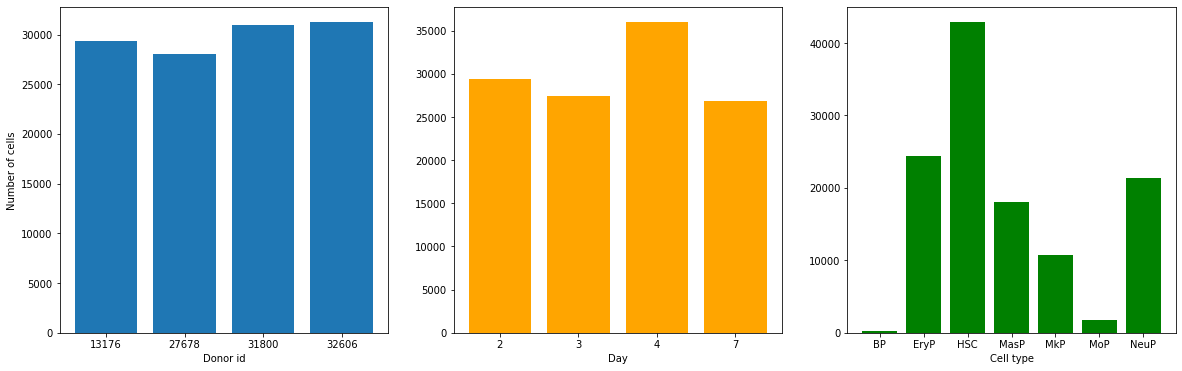

In [ ]:
fig,(ax1,ax2,ax3)=plt.subplots(1,3,figsize=(20,6))
ax1.bar(range(4), donor.values)
ax1.set(xlabel='Donor id', ylabel='Number of cells')
ax1.set_xticks(range(4),donor.index)

ax2.bar(range(4), day.values, color='orange')
ax2.set(xlabel='Day')
ax2.set_xticks(range(4),day.index)

ax3.bar(range(7), cell_type.values, color='green')
ax3.set(xlabel='Cell type')
ax3.set_xticks(range(7),cell_type.index)

plt.show()

## Input Data 

In [ ]:
input_df = pd.read_hdf(path+'train_cite_inputs.h5')
input_df.head()

gene_id,ENSG00000121410_A1BG,ENSG00000268895_A1BG-AS1,ENSG00000175899_A2M,ENSG00000245105_A2M-AS1,ENSG00000166535_A2ML1,ENSG00000128274_A4GALT,ENSG00000094914_AAAS,ENSG00000081760_AACS,ENSG00000109576_AADAT,ENSG00000103591_AAGAB,...,ENSG00000153975_ZUP1,ENSG00000086827_ZW10,ENSG00000174442_ZWILCH,ENSG00000122952_ZWINT,ENSG00000198205_ZXDA,ENSG00000198455_ZXDB,ENSG00000070476_ZXDC,ENSG00000162378_ZYG11B,ENSG00000159840_ZYX,ENSG00000074755_ZZEF1
cell_id,,,,,,,,,,,,,,,,,,,,,
45006fe3e4c8,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.00000,0.000000,4.090185,0.0
d02759a80ba2,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,4.039545,0.0,0.0,0.00000,0.000000,0.000000,0.0
c016c6b0efa5,0.0,0.0,0.0,0.0,0.0,3.847321,0.000000,3.847321,3.847321,0.0,...,0.000000,0.000000,3.847321,4.529743,0.0,0.0,0.00000,3.847321,3.847321,0.0
ba7f733a4f75,0.0,0.0,0.0,0.0,0.0,0.000000,3.436846,3.436846,0.000000,0.0,...,3.436846,0.000000,4.113780,5.020215,0.0,0.0,0.00000,3.436846,4.113780,0.0
fbcf2443ffb2,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,4.196826,0.000000,0.0,...,0.000000,4.196826,4.196826,4.196826,0.0,0.0,3.51861,4.196826,3.518610,0.0


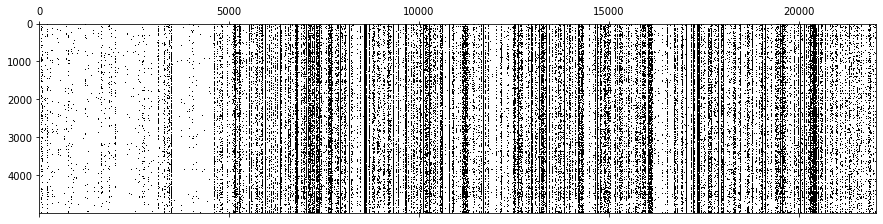

In [ ]:
plt.figure(figsize=(15,7))
plt.spy(input_df[:5000])
plt.show()

Here, the white areas represent zero values. We can see that data is very scarce.

In [ ]:
print("We have",round((input_df == 0).sum().sum()/input_df.size*100),"% of zero values in the dataset.")

We have 78 % of zero values in the dataset.


Minimum nonzero value: 2.9715922


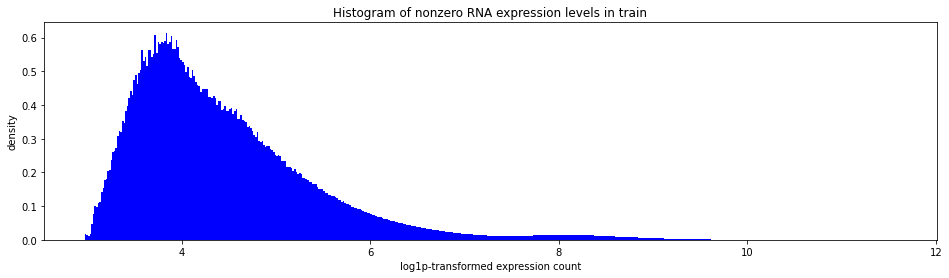

In [ ]:
nonzeros = input_df.values.ravel()
nonzeros = nonzeros[nonzeros != 0]
plt.figure(figsize=(16, 4))
plt.hist(nonzeros, bins=500, density=True, color='blue')
print('Minimum nonzero value:', nonzeros.min())
del nonzeros
plt.title("Histogram of nonzero RNA expression levels in train")
plt.xlabel("log1p-transformed expression count")
plt.ylabel("density")
plt.show()

Here, we removed the zero values (in order to avoid to have a high peak at 0) and plotted the feature values distribution.


The feature values are either 0 or between 2.9 and 12.

We will see if some columns are non significant in the dataset, for example if a gene is never expressed for all cells it will not add meaningful data:

In [ ]:
constant_col = list(input_df.columns[(input_df == 0).all(axis=0).values])

In [ ]:
input_df = input_df.drop(columns=constant_col)
input_df.shape

(70988, 21601)

We plot randomly expression level distributions for 20 genes (features) of our dataset to have an idea of the shape of the distributions.

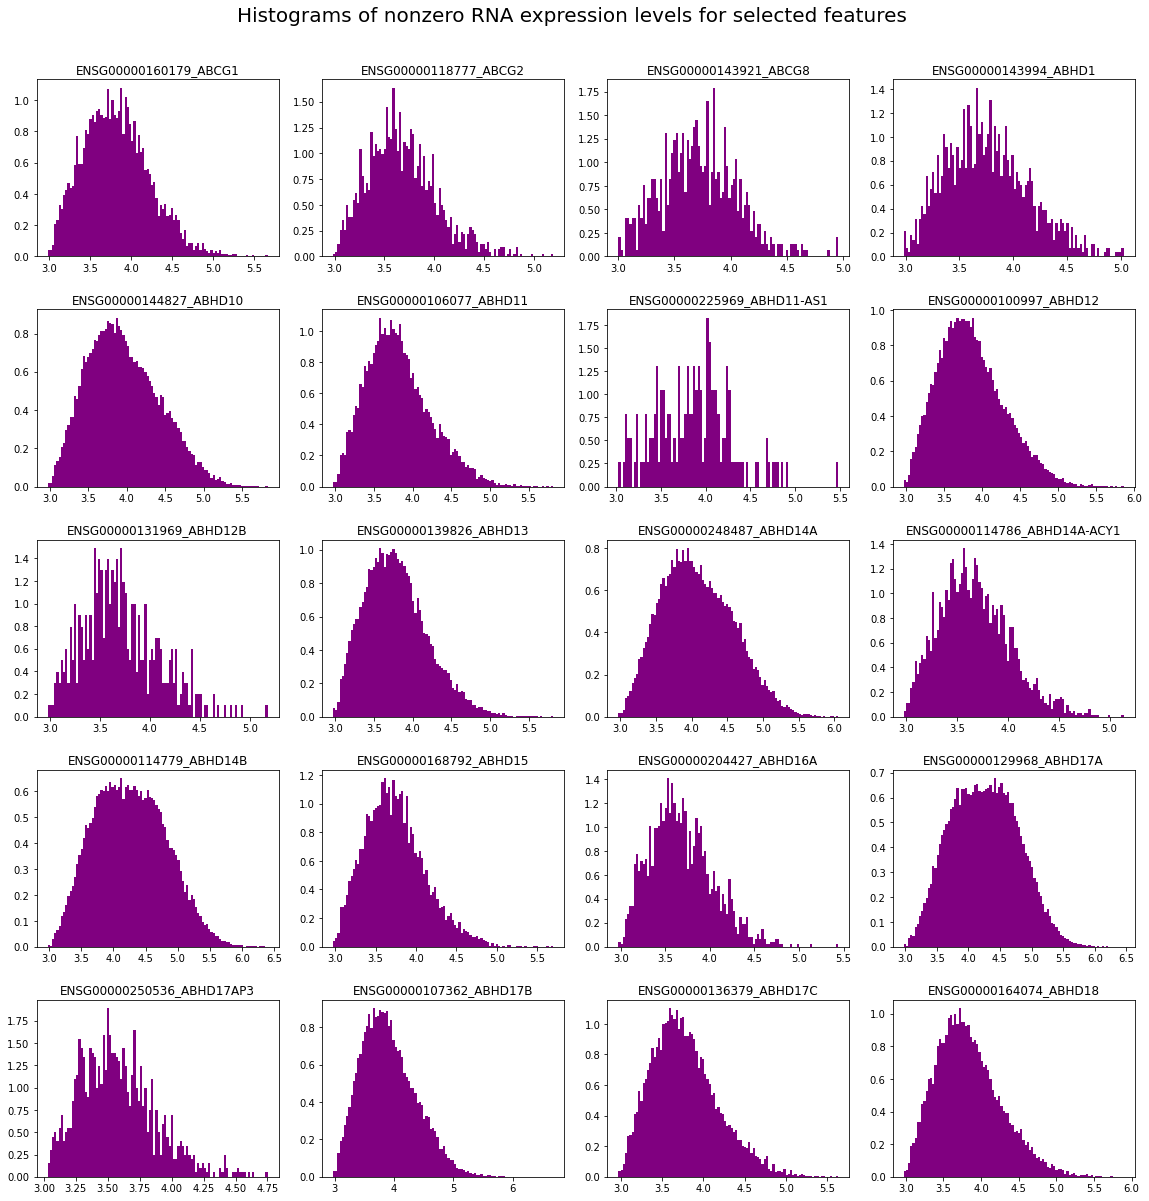

In [ ]:
_, axs = plt.subplots(5, 4, figsize=(16, 16))
for col, ax in zip(input_df.columns[60:80], axs.ravel()):
    nonzeros = input_df[col].values
    nonzeros = nonzeros[nonzeros != 0] # comment this line if you want to see the peak at zero
    ax.hist(nonzeros, bins=100, density=True, color='purple')
    ax.set_title(col)
plt.tight_layout(h_pad=2)
plt.suptitle('Histograms of nonzero RNA expression levels for selected features', fontsize=20, y=1.04)
plt.show()
del nonzeros

We can see that distributions are diverse, but the majority of features in our selection display a normal distribution. 

Let's now take a look at the target data.

## Target Data

In [ ]:
target_df = pd.read_hdf(path+'train_cite_targets.h5')
target_df.head()

gene_id,CD86,CD274,CD270,CD155,CD112,CD47,CD48,CD40,CD154,CD52,...,CD94,CD162,CD85j,CD23,CD328,HLA-E,CD82,CD101,CD88,CD224
cell_id,,,,,,,,,,,,,,,,,,,,,
45006fe3e4c8,1.167804,0.622530,0.106959,0.324989,3.331674,6.426002,1.480766,-0.728392,-0.468851,-0.073285,...,-0.448390,3.220174,-0.533004,0.674956,-0.006187,0.682148,1.398105,0.414292,1.780314,0.548070
d02759a80ba2,0.818970,0.506009,1.078682,6.848758,3.524885,5.279456,4.930438,2.069372,0.333652,-0.468088,...,0.323613,8.407108,0.131301,0.047607,-0.243628,0.547864,1.832587,0.982308,2.736507,2.184063
c016c6b0efa5,-0.356703,-0.422261,-0.824493,1.137495,0.518924,7.221962,-0.375034,1.738071,0.142919,-0.971460,...,1.348692,4.888579,-0.279483,-0.131097,-0.177604,-0.689188,9.013709,-1.182975,3.958148,2.868600
ba7f733a4f75,-1.201507,0.149115,2.022468,6.021595,7.258670,2.792436,21.708519,-0.137913,1.649969,-0.754680,...,1.504426,12.391979,0.511394,0.587863,-0.752638,1.714851,3.893782,1.799661,1.537249,4.407671
fbcf2443ffb2,-0.100404,0.697461,0.625836,-0.298404,1.369898,3.254521,-1.659380,0.643531,0.902710,1.291877,...,0.777023,6.496499,0.279898,-0.841950,-0.869419,0.675092,5.259685,-0.835379,9.631781,1.765445


In [ ]:
target_df.shape

(70988, 140)

The target dataset is much smaller than the input dataset: it is composed of 70 988 rows identifying the cells and 140 columns describing the surface protein levels.

The surface protein levels are dsb-normalized (denoised scaled by background normalization), meaning that the normalized expression estimate for the protein in each cell can be interpreted as the number of standard deviations above the expected ambient background noise of that protein.

We then plot the distribution of a few selected columns to have a look at the target data distributions.

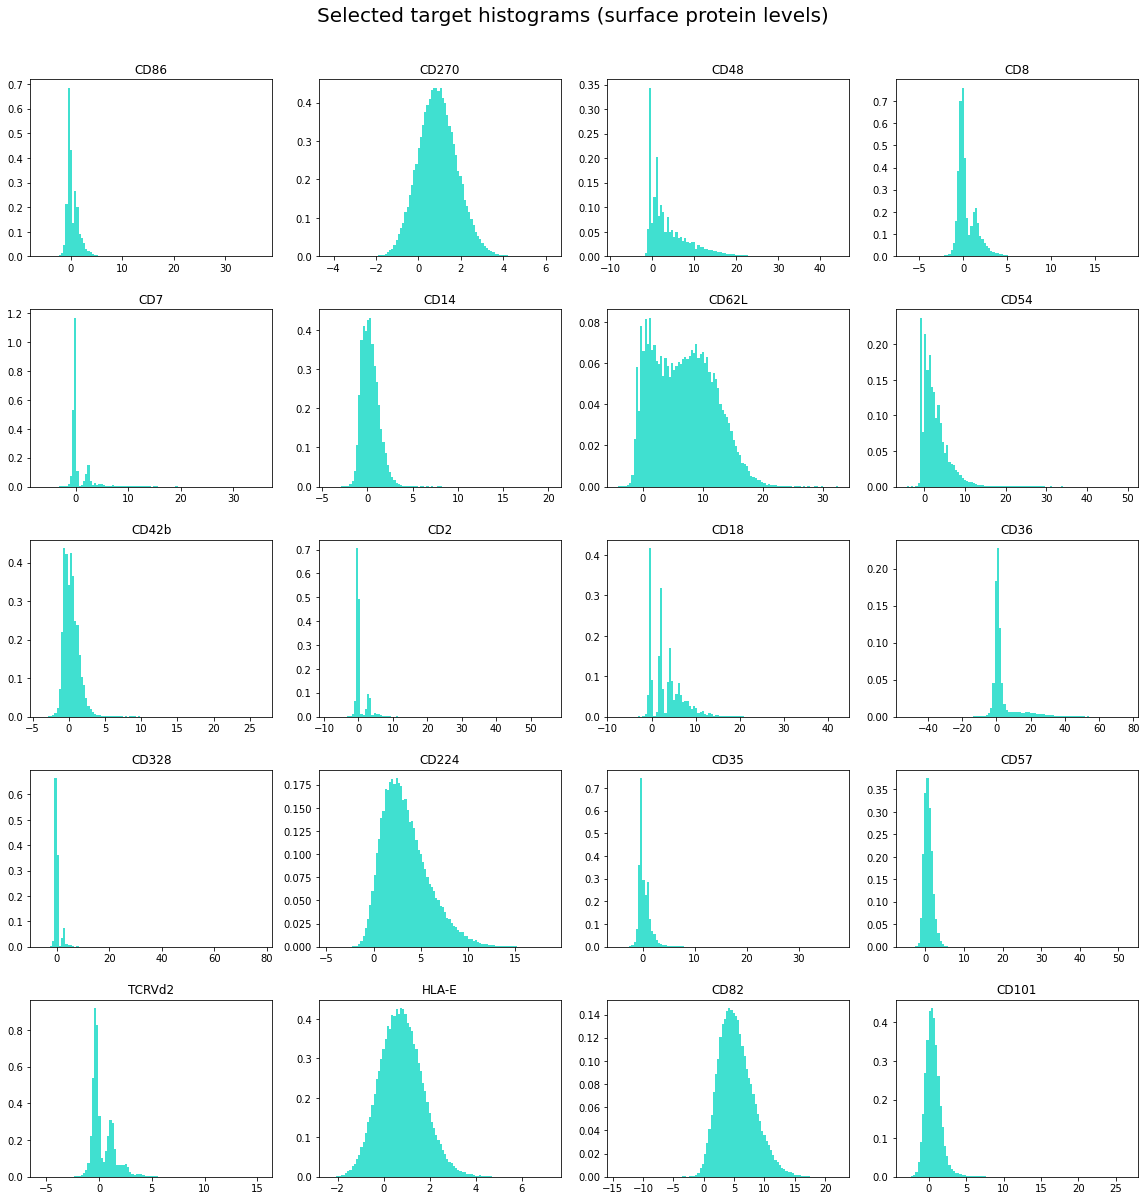

In [ ]:
_, axs = plt.subplots(5, 4, figsize=(16, 16))
for col, ax in zip(['CD86', 'CD270', 'CD48', 'CD8', 'CD7', 'CD14', 'CD62L', 'CD54', 'CD42b', 'CD2', 'CD18', 'CD36', 'CD328', 'CD224', 'CD35', 'CD57', 'TCRVd2', 'HLA-E', 'CD82', 'CD101'], axs.ravel()):
    ax.hist(target_df[col], bins=100, density=True, color='turquoise')
    ax.set_title(col)
plt.tight_layout(h_pad=2)
plt.suptitle('Selected target histograms (surface protein levels)', fontsize=20, y=1.04)
plt.show()

cite_protein_names = list(target_df.columns)

We can see that distributions vary: some columns are normally distributed, some columns are multimodal, some have other shapes, and there seem to be outliers.

## Gene - Protein name matching

We know that some genes data are directly related to protein surface levels based on their names in the dataset. For instance, the gene 'ENSG00000114013_CD86' encodes for the protein CD86. Let's look at all these types of relation in the dataset, which will help us select columns that will remain in place to feed our model.

In [ ]:
cite_gene_names = list(input_df.columns)
matching_names = []
for protein in cite_protein_names:
    matching_names += [(gene, protein) for gene in cite_gene_names if protein in gene]
pd.DataFrame(matching_names, columns=['Gene', 'Protein'])

,Gene,Protein
0,ENSG00000114013_CD86,CD86
1,ENSG00000120217_CD274,CD274
2,ENSG00000196776_CD47,CD47
3,ENSG00000117091_CD48,CD48
4,ENSG00000101017_CD40,CD40
...,...,...
144,ENSG00000102181_CD99L2,CD9
145,ENSG00000223773_CD99P1,CD9
146,ENSG00000204592_HLA-E,HLA-E
147,ENSG00000085117_CD82,CD82


We can see that 149 gene features directly impact surface protein levels. We need to make sure these 149 features are not altered in pre-processing during dimensional reduction. 

Based on this observation, we decided to select the most representative features to build our model.